# ECG Split 1D-CNN Server Side
This code is the server part of ECG split 1D-CNN model for **single** client and a server.

## Import required packages

In [13]:
mode = 'CIFAR10'

import os
import socket
import struct
import pickle
import time

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD

## Define ECG server model
Server side has **2 fully connected layers**.


In [14]:
from torchvision.models import resnet18, vgg16

NUM_CLASSES = 10
class EcgServer(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(EcgServer, self).__init__()
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x
class Resnet18_Any_Cut_Server(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.logits = config["logits"]
    self.cut_layer = config["cut_layer"]

    self.model = resnet18(weights = None)

    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Sequential(nn.Flatten(), nn.Linear(num_ftrs, self.logits))

    self.model = nn.ModuleList(self.model.children()) # These 2 lines help us iterate over the layers (blocks)
    self.model = nn.Sequential(*self.model)


  def forward(self, x):
    for i, layer in enumerate(self.model):
      if i <= self.cut_layer:
        continue
      else:
        x = layer(x)
    m = nn.Softmax(dim = 1)

    return m(x)
  
class VGG16_Any_Cut_Server(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.logits = config["logits"]
        self.cut_layer = config["cut_layer"]

        self.model = vgg16(weights=None)

        # Modify the classifier's last layer
        num_features = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Sequential(nn.Flatten(), nn.Linear(num_features, self.logits))

        # Convert the model to a list of layers for easier manipulation
        features = list(self.model.features.children())
        classifier = list(self.model.classifier.children())
        self.model = nn.Sequential(*(features + classifier))

    def forward(self, x):
        for i, layer in enumerate(self.model):
            if i <= self.cut_layer:
                continue
            else:
                x = layer(x)
        m = nn.Softmax(dim=1)
        return m(x)

In [15]:
device = torch.device('cuda:0')
torch.cuda.get_device_name(0)
assert('cuda' in device.type)

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

cut_layer = 3
logits = 10

config = {"cut_layer":cut_layer, "logits":logits}
ecg_server = VGG16_Any_Cut_Server(config)
ecg_server.to(device)

# checkpoint = torch.load(f"../ecg_2conv/init_weight{mode}.pth")
# ecg_server.linear3.weight.data = checkpoint["linear3.weight"]
# ecg_server.linear3.bias.data = checkpoint["linear3.bias"]
# ecg_server.linear4.weight.data = checkpoint["linear4.weight"]
# ecg_server.linear4.bias.data = checkpoint["linear4.bias"]

batch_size = 32
if mode == 'ECG':
    total_batch = 414
    total_test_batch = 414
elif mode == 'CIFAR10':
    total_batch = 1563
    total_test_batch = 313


epoch = 400
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = Adam(ecg_server.parameters(), lr=lr)

def send_msg(sock, msg):
    # prefix each message with a 4-byte length in network byte order
    msg = struct.pack('>I', len(msg)) + msg
    sock.sendall(msg)

def recv_msg(sock):
    # read message length and unpack it into an integer
    raw_msglen = recvall(sock, 4)
    if not raw_msglen:
        return None
    msglen = struct.unpack('>I', raw_msglen)[0]
    # read the message data
    return recvall(sock, msglen)

def recvall(sock, n):
    # helper function to receive n bytes or return None if EOF is hit
    data = b''
    while len(data) < n:
        packet = sock.recv(n - len(data))
        if not packet:
            return None
        data += packet
    return data

host = 'localhost'
port = 10080
max_recv = 4096

s = socket.socket()
s.bind((host, port))
s.listen(5)

conn, addr = s.accept()
print('Conntected with', addr)

Conntected with ('127.0.0.1', 63207)


## Real training process

In [16]:
train_losses = list()
train_accs = list()
test_losses = list()
test_accs = list()
best_test_acc = 0  # best test accuracy

for e in range(epoch):
    print("Epoch {} - ".format(e+1), end='')
    
    train_loss = 0.0
    correct, total = 0, 0
    for i in range(total_batch):
        optimizer.zero_grad()  # initialize all gradients to zero
        msg = recv_msg(conn)  # receive client message from socket
        msg = pickle.loads(msg)  # deserialize
        client_output = msg['client_output']  # client output tensor
        label = msg['label']  # label
        client_output, label = client_output.to(device), label.to(device)
        ecg_server = ecg_server.to(device)
        output = ecg_server(client_output)  # forward propagation
        loss = criterion(output, label)  # calculates cross-entropy loss
        loss.backward()  # backward propagation
        client_grad = client_output.grad.clone().detach()
        msg = pickle.dumps(client_grad)
        send_msg(conn, msg)
        optimizer.step()
        
        train_loss += loss.item()
        correct += torch.sum(output.argmax(dim=1) == label).item()
        total += len(label)
    train_losses.append(train_loss / total_batch)
    train_accs.append(correct / total)
    train_status = "loss: {:.4f}, acc: {:.2f}% / ".format(train_losses[-1], train_accs[-1]*100)
    print(train_status, end='')
        
    with torch.no_grad():  # calculate test accuracy
        test_loss = 0.0
        correct, total = 0, 0
        for j in range(total_test_batch):
            msg = recv_msg(conn)
            msg = pickle.loads(msg)
            client_output = msg['client_output']
            test_label = msg['label']
            client_output, test_label = client_output.to(device), test_label.to(device)
            test_output = ecg_server(client_output)
            loss = criterion(test_output, test_label)
            
            test_loss += loss.item()
            correct += torch.sum(test_output.argmax(dim=1) == test_label).item()
            total += len(test_label)
        test_losses.append(test_loss / total_batch)
        test_accs.append(correct / total)
        test_status = "test_loss: {:.4f}, test_acc: {:.2f}%".format(test_losses[-1], test_accs[-1]*100)
        print(test_status)
        
    if test_accs[-1] > best_test_acc:
        best_test_acc = test_accs[-1]
    
    msg = pickle.dumps(train_status + test_status)
    send_msg(conn, msg)

Epoch 1 - 

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16384x1 and 25088x4096)

In [ ]:
best_test_acc_epoch = np.array(test_accs).argmax() + 1
print('Best test accuracy {:.2f}% in epoch {}.'.format(best_test_acc*100, best_test_acc_epoch))

Best test accuracy 98.44% in epoch 314.


In [ ]:
df = pd.DataFrame({  # save model training process into csv file
        'loss': train_losses,
        'test_loss': test_losses,
        'acc': train_accs,
        'test_acc': test_accs
    })
df.to_csv(os.path.join('csv', 'loss_and_acc.csv'))

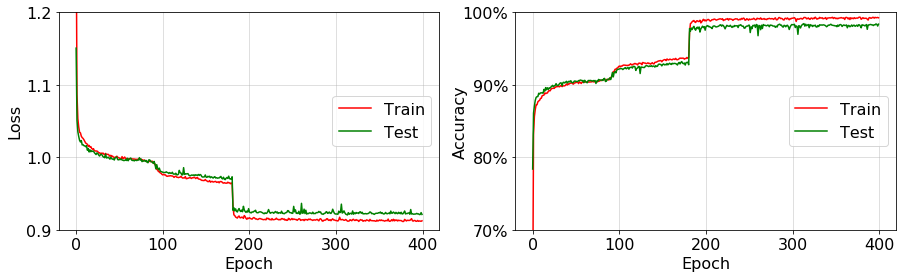

In [ ]:
df = pd.read_csv(os.path.join('csv', 'loss_and_acc.csv'))
test_accs = df['test_acc']
train_accs = df['acc']
test_losses = df['test_loss']
train_losses = df['loss']

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(train_losses, color='red')
ax[0].plot(test_losses, color='green')
ax[0].set_xticks([0, 100, 200, 300, 400])
ax[0].set_xlabel('Epoch', size=16)
ax[0].set_ylabel('Loss', size=16)
ax[0].set_ylim(0.9, 1.1)
ax[0].set_yticks([0.9, 1.0, 1.1, 1.2])
ax[0].grid(alpha=0.5)
ax[0].tick_params(labelsize=16)
ax[0].legend(['Train', 'Test'], loc='right', fontsize=16)


ax[1].set_ylim(0.7, 1.0)
ax[1].set_yticks([0.7, 0.8, 0.9, 1.0])
ax[1].plot(train_accs, color='red')
ax[1].plot(test_accs, color='green')
yt = ax[1].get_yticks()
ax[1].set_yticklabels(['{:,.0%}'.format(x) for x in yt])
ax[1].set_xticks([0, 100, 200, 300, 400])
ax[1].set_xlabel('Epoch', size=16)
ax[1].set_ylabel('Accuracy', size=16, labelpad=-5)
ax[1].grid(alpha=0.5)
ax[1].tick_params(labelsize=16)
ax[1].legend(['Train', 'Test'], loc='right', fontsize=16)

fig.savefig('loss_acc_conv2_split_seed.pdf', bbox_inches='tight')

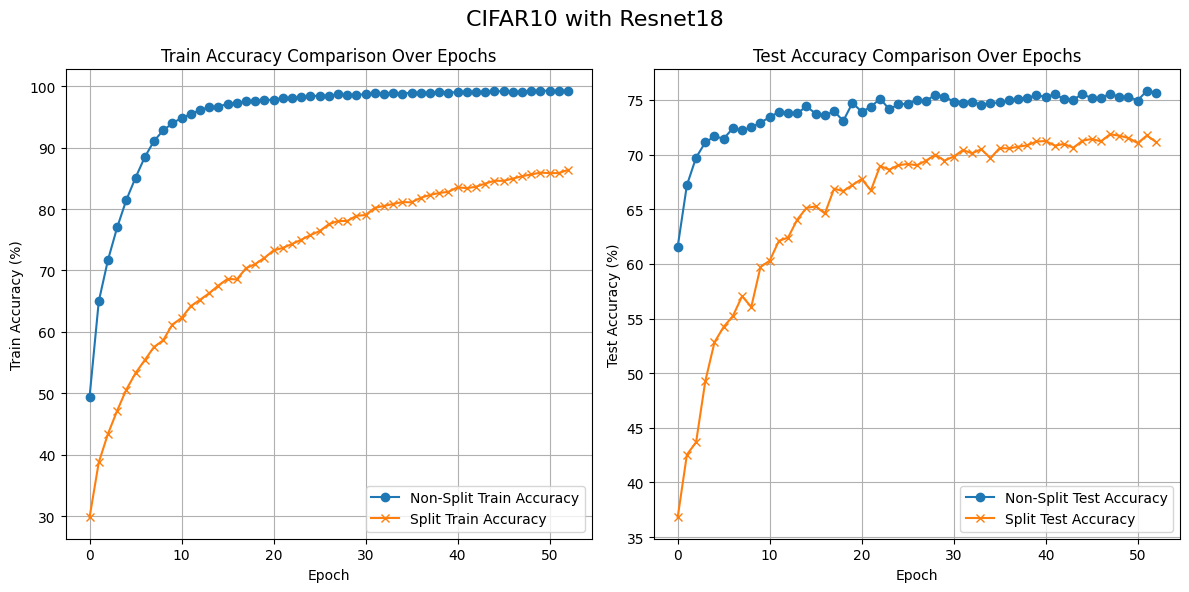

In [ ]:
# Resnet
split_ver = """Epoch 1 - loss: 2.1550, acc: 29.80% / test_loss: 0.4179, test_acc: 36.80%
Epoch 2 - loss: 2.0671, acc: 38.76% / test_loss: 0.4067, test_acc: 42.54%
Epoch 3 - loss: 2.0222, acc: 43.40% / test_loss: 0.4041, test_acc: 43.68%
Epoch 4 - loss: 1.9852, acc: 47.18% / test_loss: 0.3933, test_acc: 49.26%
Epoch 5 - loss: 1.9512, acc: 50.62% / test_loss: 0.3862, test_acc: 52.83%
Epoch 6 - loss: 1.9256, acc: 53.30% / test_loss: 0.3835, test_acc: 54.24%
Epoch 7 - loss: 1.9042, acc: 55.41% / test_loss: 0.3815, test_acc: 55.23%
Epoch 8 - loss: 1.8833, acc: 57.54% / test_loss: 0.3785, test_acc: 57.04%
Epoch 9 - loss: 1.8712, acc: 58.63% / test_loss: 0.3799, test_acc: 56.06%
Epoch 10 - loss: 1.8472, acc: 61.20% / test_loss: 0.3726, test_acc: 59.72%
Epoch 11 - loss: 1.8364, acc: 62.27% / test_loss: 0.3714, test_acc: 60.29%
Epoch 12 - loss: 1.8180, acc: 64.19% / test_loss: 0.3682, test_acc: 62.10%
Epoch 13 - loss: 1.8075, acc: 65.23% / test_loss: 0.3672, test_acc: 62.41%
Epoch 14 - loss: 1.7965, acc: 66.30% / test_loss: 0.3640, test_acc: 64.06%
Epoch 15 - loss: 1.7839, acc: 67.55% / test_loss: 0.3618, test_acc: 65.12%
Epoch 16 - loss: 1.7733, acc: 68.63% / test_loss: 0.3619, test_acc: 65.26%
Epoch 17 - loss: 1.7736, acc: 68.55% / test_loss: 0.3633, test_acc: 64.61%
Epoch 18 - loss: 1.7559, acc: 70.37% / test_loss: 0.3584, test_acc: 66.88%
Epoch 19 - loss: 1.7493, acc: 71.04% / test_loss: 0.3593, test_acc: 66.66%
Epoch 20 - loss: 1.7395, acc: 72.05% / test_loss: 0.3580, test_acc: 67.22%
Epoch 21 - loss: 1.7272, acc: 73.27% / test_loss: 0.3568, test_acc: 67.76%
Epoch 22 - loss: 1.7235, acc: 73.68% / test_loss: 0.3589, test_acc: 66.72%
Epoch 23 - loss: 1.7170, acc: 74.31% / test_loss: 0.3544, test_acc: 68.96%
Epoch 24 - loss: 1.7102, acc: 75.00% / test_loss: 0.3550, test_acc: 68.62%
Epoch 25 - loss: 1.7025, acc: 75.76% / test_loss: 0.3542, test_acc: 69.03%
Epoch 26 - loss: 1.6959, acc: 76.41% / test_loss: 0.3542, test_acc: 69.14%
Epoch 27 - loss: 1.6852, acc: 77.53% / test_loss: 0.3544, test_acc: 69.02%
Epoch 28 - loss: 1.6799, acc: 78.06% / test_loss: 0.3536, test_acc: 69.45%
Epoch 29 - loss: 1.6799, acc: 78.06% / test_loss: 0.3524, test_acc: 69.99%
Epoch 30 - loss: 1.6713, acc: 78.90% / test_loss: 0.3534, test_acc: 69.45%
Epoch 31 - loss: 1.6702, acc: 79.03% / test_loss: 0.3527, test_acc: 69.82%
Epoch 32 - loss: 1.6579, acc: 80.21% / test_loss: 0.3516, test_acc: 70.41%
Epoch 33 - loss: 1.6553, acc: 80.51% / test_loss: 0.3522, test_acc: 70.12%
Epoch 34 - loss: 1.6522, acc: 80.83% / test_loss: 0.3514, test_acc: 70.49%
Epoch 35 - loss: 1.6495, acc: 81.14% / test_loss: 0.3533, test_acc: 69.68%
Epoch 36 - loss: 1.6496, acc: 81.10% / test_loss: 0.3511, test_acc: 70.60%
Epoch 37 - loss: 1.6421, acc: 81.84% / test_loss: 0.3511, test_acc: 70.56%
Epoch 38 - loss: 1.6375, acc: 82.30% / test_loss: 0.3509, test_acc: 70.72%
Epoch 39 - loss: 1.6346, acc: 82.62% / test_loss: 0.3507, test_acc: 70.85%
Epoch 40 - loss: 1.6325, acc: 82.81% / test_loss: 0.3501, test_acc: 71.20%
Epoch 41 - loss: 1.6256, acc: 83.54% / test_loss: 0.3499, test_acc: 71.24%
Epoch 42 - loss: 1.6264, acc: 83.40% / test_loss: 0.3507, test_acc: 70.82%
Epoch 43 - loss: 1.6249, acc: 83.63% / test_loss: 0.3504, test_acc: 70.97%
Epoch 44 - loss: 1.6191, acc: 84.15% / test_loss: 0.3510, test_acc: 70.63%
Epoch 45 - loss: 1.6147, acc: 84.61% / test_loss: 0.3498, test_acc: 71.27%
Epoch 46 - loss: 1.6147, acc: 84.60% / test_loss: 0.3494, test_acc: 71.43%
Epoch 47 - loss: 1.6111, acc: 84.96% / test_loss: 0.3499, test_acc: 71.21%
Epoch 48 - loss: 1.6071, acc: 85.35% / test_loss: 0.3487, test_acc: 71.86%
Epoch 49 - loss: 1.6043, acc: 85.64% / test_loss: 0.3489, test_acc: 71.73%
Epoch 50 - loss: 1.6015, acc: 85.93% / test_loss: 0.3494, test_acc: 71.52%
Epoch 51 - loss: 1.6023, acc: 85.86% / test_loss: 0.3503, test_acc: 71.05%
Epoch 52 - loss: 1.6022, acc: 85.86% / test_loss: 0.3488, test_acc: 71.75%
Epoch 53 - loss: 1.5970, acc: 86.38% / test_loss: 0.3501, test_acc: 71.15%"""

non_split = """Epoch 1 - loss: 1.4174, acc: 49.42% / test_loss: 1.1199, test_acc: 61.57%
Epoch 2 - loss: 1.0103, acc: 64.97% / test_loss: 0.9608, test_acc: 67.20%
Epoch 3 - loss: 0.8196, acc: 71.71% / test_loss: 0.9102, test_acc: 69.73%
Epoch 4 - loss: 0.6657, acc: 77.02% / test_loss: 0.9075, test_acc: 71.11%
Epoch 5 - loss: 0.5340, acc: 81.50% / test_loss: 0.9465, test_acc: 71.67%
Epoch 6 - loss: 0.4244, acc: 85.12% / test_loss: 1.0331, test_acc: 71.46%
Epoch 7 - loss: 0.3309, acc: 88.45% / test_loss: 1.0590, test_acc: 72.41%
Epoch 8 - loss: 0.2573, acc: 91.08% / test_loss: 1.2046, test_acc: 72.23%
Epoch 9 - loss: 0.2047, acc: 92.81% / test_loss: 1.2543, test_acc: 72.49%
Epoch 10 - loss: 0.1711, acc: 93.97% / test_loss: 1.2639, test_acc: 72.93%
Epoch 11 - loss: 0.1460, acc: 94.84% / test_loss: 1.3084, test_acc: 73.42%
Epoch 12 - loss: 0.1302, acc: 95.45% / test_loss: 1.3575, test_acc: 73.91%
Epoch 13 - loss: 0.1125, acc: 96.13% / test_loss: 1.3641, test_acc: 73.82%
Epoch 14 - loss: 0.1001, acc: 96.58% / test_loss: 1.4896, test_acc: 73.77%
Epoch 15 - loss: 0.0943, acc: 96.70% / test_loss: 1.4130, test_acc: 74.42%
Epoch 16 - loss: 0.0833, acc: 97.11% / test_loss: 1.5109, test_acc: 73.74%
Epoch 17 - loss: 0.0802, acc: 97.24% / test_loss: 1.5460, test_acc: 73.59%
Epoch 18 - loss: 0.0725, acc: 97.52% / test_loss: 1.5370, test_acc: 73.96%
Epoch 19 - loss: 0.0692, acc: 97.64% / test_loss: 1.5497, test_acc: 73.09%
Epoch 20 - loss: 0.0637, acc: 97.72% / test_loss: 1.5114, test_acc: 74.73%
Epoch 21 - loss: 0.0616, acc: 97.83% / test_loss: 1.5714, test_acc: 73.92%
Epoch 22 - loss: 0.0550, acc: 98.09% / test_loss: 1.5891, test_acc: 74.36%
Epoch 23 - loss: 0.0545, acc: 98.10% / test_loss: 1.5796, test_acc: 75.13%
Epoch 24 - loss: 0.0505, acc: 98.22% / test_loss: 1.6479, test_acc: 74.14%
Epoch 25 - loss: 0.0464, acc: 98.43% / test_loss: 1.6068, test_acc: 74.60%
Epoch 26 - loss: 0.0465, acc: 98.43% / test_loss: 1.6084, test_acc: 74.65%
Epoch 27 - loss: 0.0478, acc: 98.35% / test_loss: 1.6516, test_acc: 75.00%
Epoch 28 - loss: 0.0394, acc: 98.70% / test_loss: 1.6351, test_acc: 74.90%
Epoch 29 - loss: 0.0426, acc: 98.55% / test_loss: 1.6631, test_acc: 75.49%
Epoch 30 - loss: 0.0443, acc: 98.54% / test_loss: 1.6218, test_acc: 75.31%
Epoch 31 - loss: 0.0381, acc: 98.75% / test_loss: 1.6421, test_acc: 74.84%
Epoch 32 - loss: 0.0330, acc: 98.89% / test_loss: 1.6497, test_acc: 74.75%
Epoch 33 - loss: 0.0376, acc: 98.80% / test_loss: 1.6892, test_acc: 74.85%
Epoch 34 - loss: 0.0314, acc: 98.91% / test_loss: 1.7663, test_acc: 74.55%
Epoch 35 - loss: 0.0384, acc: 98.77% / test_loss: 1.6455, test_acc: 74.70%
Epoch 36 - loss: 0.0293, acc: 98.98% / test_loss: 1.8655, test_acc: 74.78%
Epoch 37 - loss: 0.0316, acc: 98.93% / test_loss: 1.7909, test_acc: 74.98%
Epoch 38 - loss: 0.0305, acc: 98.96% / test_loss: 1.8308, test_acc: 75.10%
Epoch 39 - loss: 0.0267, acc: 99.07% / test_loss: 1.8862, test_acc: 75.19%
Epoch 40 - loss: 0.0308, acc: 98.96% / test_loss: 1.8111, test_acc: 75.43%
Epoch 41 - loss: 0.0266, acc: 99.05% / test_loss: 1.8799, test_acc: 75.28%
Epoch 42 - loss: 0.0280, acc: 99.07% / test_loss: 1.8657, test_acc: 75.52%
Epoch 43 - loss: 0.0262, acc: 99.07% / test_loss: 1.8470, test_acc: 75.08%
Epoch 44 - loss: 0.0275, acc: 99.04% / test_loss: 1.8460, test_acc: 75.04%
Epoch 45 - loss: 0.0250, acc: 99.17% / test_loss: 1.8008, test_acc: 75.54%
Epoch 46 - loss: 0.0243, acc: 99.19% / test_loss: 1.9129, test_acc: 75.16%
Epoch 47 - loss: 0.0275, acc: 99.06% / test_loss: 1.9035, test_acc: 75.15%
Epoch 48 - loss: 0.0253, acc: 99.12% / test_loss: 1.8453, test_acc: 75.59%
Epoch 49 - loss: 0.0223, acc: 99.27% / test_loss: 1.8395, test_acc: 75.26%
Epoch 50 - loss: 0.0218, acc: 99.28% / test_loss: 1.8724, test_acc: 75.30%
Epoch 51 - loss: 0.0212, acc: 99.26% / test_loss: 1.9569, test_acc: 74.95%
Epoch 52 - loss: 0.0227, acc: 99.19% / test_loss: 1.8026, test_acc: 75.85%
Epoch 53 - loss: 0.0218, acc: 99.27% / test_loss: 1.8688, test_acc: 75.67%"""
import matplotlib.pyplot as plt

def plot_train_and_test_accuracy(non_split, split, model_name):
    # Function to extract both train and test accuracy values from a given string
    def extract_acc_values(data):
        lines = data.split('\n')
        train_acc_values = []
        test_acc_values = []
        for line in lines:
            if "acc" in line:
                # Extracting the train and test accuracy percentages
                train_acc = float(line.split('acc: ')[1].split('%')[0])
                test_acc = float(line.split('test_acc: ')[1].split('%')[0])
                train_acc_values.append(train_acc)
                test_acc_values.append(test_acc)
        return train_acc_values, test_acc_values

    # Extracting accuracy values from both strings
    non_split_train_acc, non_split_test_acc = extract_acc_values(non_split)
    split_train_acc, split_test_acc = extract_acc_values(split)

    # Plotting Train Accuracy
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(non_split_train_acc, marker='o', label='Non-Split Train Accuracy')
    plt.plot(split_train_acc, marker='x', label='Split Train Accuracy')
    plt.title('Train Accuracy Comparison Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Plotting Test Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(non_split_test_acc, marker='o', label='Non-Split Test Accuracy')
    plt.plot(split_test_acc, marker='x', label='Split Test Accuracy')
    plt.title('Test Accuracy Comparison Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.suptitle(f'CIFAR10 with {model_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_train_and_test_accuracy(non_split, split_ver, "Resnet18")

In [ ]:
split_ver_alex = """Epoch 1 - loss: 1.6747, acc: 35.32% / test_loss: 0.2795, test_acc: 48.48%
Epoch 2 - loss: 1.2900, acc: 53.77% / test_loss: 0.2339, test_acc: 58.39%
Epoch 3 - loss: 1.1324, acc: 60.20% / test_loss: 0.2249, test_acc: 61.40%
Epoch 4 - loss: 1.0315, acc: 63.73% / test_loss: 0.2235, test_acc: 62.51%
Epoch 5 - loss: 0.9661, acc: 66.24% / test_loss: 0.2242, test_acc: 63.38%
Epoch 6 - loss: 0.9013, acc: 68.68% / test_loss: 0.2295, test_acc: 63.76%
Epoch 7 - loss: 0.8553, acc: 70.39% / test_loss: 0.2117, test_acc: 64.76%
Epoch 8 - loss: 0.8076, acc: 71.95% / test_loss: 0.2191, test_acc: 65.45%
Epoch 9 - loss: 0.7699, acc: 73.43% / test_loss: 0.2259, test_acc: 65.35%
Epoch 10 - loss: 0.7487, acc: 74.09% / test_loss: 0.2201, test_acc: 66.64%
Epoch 11 - loss: 0.7088, acc: 75.83% / test_loss: 0.2283, test_acc: 66.27%
Epoch 12 - loss: 0.6851, acc: 76.29% / test_loss: 0.2405, test_acc: 66.48%
Epoch 13 - loss: 0.6550, acc: 77.57% / test_loss: 0.2363, test_acc: 66.90%
Epoch 14 - loss: 0.6220, acc: 78.60% / test_loss: 0.2327, test_acc: 67.34%
Epoch 15 - loss: 0.5927, acc: 79.85% / test_loss: 0.2513, test_acc: 67.18%
Epoch 16 - loss: 0.5683, acc: 80.68% / test_loss: 0.2561, test_acc: 66.88%
Epoch 17 - loss: 0.5517, acc: 81.27% / test_loss: 0.2553, test_acc: 66.66%
Epoch 18 - loss: 0.5268, acc: 82.22% / test_loss: 0.2757, test_acc: 65.62%
Epoch 19 - loss: 0.5181, acc: 82.63% / test_loss: 0.2778, test_acc: 66.59%
Epoch 20 - loss: 0.4978, acc: 83.29% / test_loss: 0.2767, test_acc: 67.57%
Epoch 21 - loss: 0.4918, acc: 83.82% / test_loss: 0.2823, test_acc: 67.79%
Epoch 22 - loss: 0.4601, acc: 84.77% / test_loss: 0.2937, test_acc: 66.61%
Epoch 23 - loss: 0.4512, acc: 85.01% / test_loss: 0.3119, test_acc: 67.03%
Epoch 24 - loss: 0.4352, acc: 85.87% / test_loss: 0.3061, test_acc: 67.58%
Epoch 25 - loss: 0.5672, acc: 81.70% / test_loss: 0.2589, test_acc: 68.16%
Epoch 26 - loss: 0.4145, acc: 86.60% / test_loss: 0.2967, test_acc: 67.65%
Epoch 27 - loss: 0.4243, acc: 86.53% / test_loss: 0.2955, test_acc: 68.78%
Epoch 28 - loss: 0.3976, acc: 87.51% / test_loss: 0.3389, test_acc: 68.11%
Epoch 29 - loss: 0.3906, acc: 87.60% / test_loss: 0.3846, test_acc: 66.99%
Epoch 30 - loss: 0.3865, acc: 88.03% / test_loss: 0.4122, test_acc: 66.08%
Epoch 31 - loss: 0.3753, acc: 88.24% / test_loss: 0.3423, test_acc: 67.75%
Epoch 32 - loss: 0.3652, acc: 88.70% / test_loss: 0.4308, test_acc: 66.68%
Epoch 33 - loss: 0.3632, acc: 88.88% / test_loss: 0.3655, test_acc: 68.09%
Epoch 34 - loss: 0.4154, acc: 87.58% / test_loss: 0.4109, test_acc: 67.12%
Epoch 35 - loss: 0.3560, acc: 89.34% / test_loss: 0.3894, test_acc: 67.90%
Epoch 36 - loss: 0.4519, acc: 86.62% / test_loss: 0.3690, test_acc: 68.11%
Epoch 37 - loss: 0.3566, acc: 89.19% / test_loss: 0.3442, test_acc: 67.40%
Epoch 38 - loss: 0.3368, acc: 90.17% / test_loss: 0.3683, test_acc: 68.24%
Epoch 39 - loss: 0.3180, acc: 90.68% / test_loss: 0.3541, test_acc: 66.82%
Epoch 40 - loss: 0.3922, acc: 88.32% / test_loss: 0.4126, test_acc: 68.11%
Epoch 41 - loss: 0.3437, acc: 89.89% / test_loss: 0.3751, test_acc: 68.70%
Epoch 42 - loss: 0.3729, acc: 89.28% / test_loss: 0.3748, test_acc: 68.11%
Epoch 43 - loss: 0.3115, acc: 91.00% / test_loss: 0.4389, test_acc: 67.59%
Epoch 44 - loss: 0.3040, acc: 91.34% / test_loss: 0.4407, test_acc: 67.34%
Epoch 45 - loss: 0.3873, acc: 89.02% / test_loss: 0.4212, test_acc: 66.82%
Epoch 46 - loss: 0.4702, acc: 86.18% / test_loss: 0.3971, test_acc: 67.46%
Epoch 47 - loss: 0.3698, acc: 89.18% / test_loss: 0.5113, test_acc: 68.36%
Epoch 48 - loss: 0.4591, acc: 86.51% / test_loss: 0.4116, test_acc: 66.92%
Epoch 49 - loss: 0.3771, acc: 89.24% / test_loss: 0.4078, test_acc: 69.08%
Epoch 50 - loss: 0.3258, acc: 90.86% / test_loss: 0.4623, test_acc: 68.21%
Epoch 51 - loss: 0.4052, acc: 89.85% / test_loss: 0.5867, test_acc: 51.76%
Epoch 52 - loss: 0.7226, acc: 78.39% / test_loss: 0.2579, test_acc: 66.53%
Epoch 53 - loss: 0.3535, acc: 89.70% / test_loss: 0.4867, test_acc: 67.96%
Epoch 54 - loss: 0.3525, acc: 90.52% / test_loss: 0.3673, test_acc: 68.05%
Epoch 55 - loss: 0.3274, acc: 90.97% / test_loss: 0.6249, test_acc: 68.47%
Epoch 56 - loss: 0.2852, acc: 92.20% / test_loss: 0.4686, test_acc: 67.14%
Epoch 57 - loss: 0.3627, acc: 90.32% / test_loss: 0.4676, test_acc: 67.47%
Epoch 58 - loss: 0.9553, acc: 71.13% / test_loss: 0.3021, test_acc: 65.00%
Epoch 59 - loss: 0.4443, acc: 87.52% / test_loss: 0.3213, test_acc: 65.77%
Epoch 60 - loss: 0.3754, acc: 89.60% / test_loss: 0.6603, test_acc: 67.82%
Epoch 61 - loss: 0.8258, acc: 75.20% / test_loss: 0.3163, test_acc: 65.80%
Epoch 62 - loss: 0.4482, acc: 87.29% / test_loss: 0.4434, test_acc: 68.61%
Epoch 63 - loss: 0.3384, acc: 90.94% / test_loss: 0.7012, test_acc: 67.26%
Epoch 64 - loss: 0.3888, acc: 89.54% / test_loss: 0.5024, test_acc: 68.27%
Epoch 65 - loss: 0.5065, acc: 86.46% / test_loss: 0.3388, test_acc: 66.79%
Epoch 66 - loss: 0.4311, acc: 88.13% / test_loss: 0.3933, test_acc: 65.62%
Epoch 67 - loss: 0.3317, acc: 90.95% / test_loss: 0.6326, test_acc: 68.42%
Epoch 68 - loss: 0.4643, acc: 87.64% / test_loss: 0.3963, test_acc: 66.19%
Epoch 69 - loss: 0.3442, acc: 90.84% / test_loss: 0.7053, test_acc: 68.09%
Epoch 70 - loss: 0.4565, acc: 88.59% / test_loss: 0.4315, test_acc: 21.27%
Epoch 71 - loss: 1.4006, acc: 54.31% / test_loss: 0.2668, test_acc: 61.34%
Epoch 72 - loss: 0.7509, acc: 76.99% / test_loss: 0.3459, test_acc: 66.52%
Epoch 73 - loss: 0.8188, acc: 75.88% / test_loss: 0.2837, test_acc: 64.87%
Epoch 74 - loss: 0.5907, acc: 82.47% / test_loss: 0.3520, test_acc: 67.10%
Epoch 75 - loss: 0.9308, acc: 76.09% / test_loss: 0.3032, test_acc: 53.56%
Epoch 76 - loss: 0.9373, acc: 71.40% / test_loss: 0.3259, test_acc: 65.56%
Epoch 77 - loss: 0.5920, acc: 82.89% / test_loss: 0.6090, test_acc: 67.64%
Epoch 78 - loss: 0.8068, acc: 76.17% / test_loss: 0.2734, test_acc: 61.20%
Epoch 79 - loss: 0.5462, acc: 84.04% / test_loss: 0.5086, test_acc: 67.99%
Epoch 80 - loss: 0.4719, acc: 86.73% / test_loss: 0.4725, test_acc: 67.49%
Epoch 81 - loss: 2.2183, acc: 77.85% / test_loss: 0.3176, test_acc: 61.33%
Epoch 82 - loss: 0.7640, acc: 77.42% / test_loss: 0.3305, test_acc: 66.19%
Epoch 83 - loss: 0.5410, acc: 84.76% / test_loss: 0.6146, test_acc: 67.00%
Epoch 84 - loss: 0.4701, acc: 86.93% / test_loss: 0.5575, test_acc: 67.98%
Epoch 85 - loss: 0.6550, acc: 81.93% / test_loss: 0.3005, test_acc: 60.45%
Epoch 86 - loss: 0.6419, acc: 81.49% / test_loss: 0.3832, test_acc: 67.48%
Epoch 87 - loss: 0.5650, acc: 84.71% / test_loss: 0.6001, test_acc: 67.23%
Epoch 88 - loss: 0.5071, acc: 86.14% / test_loss: 0.5059, test_acc: 68.23%
Epoch 89 - loss: 0.5182, acc: 85.98% / test_loss: 0.4254, test_acc: 63.79%
Epoch 90 - loss: 0.4902, acc: 87.12% / test_loss: 0.3779, test_acc: 64.54%
Epoch 91 - loss: 0.5998, acc: 84.06% / test_loss: 0.3915, test_acc: 66.44%
Epoch 92 - loss: 0.3817, acc: 89.69% / test_loss: 0.6369, test_acc: 67.61%
Epoch 93 - loss: 0.5369, acc: 86.08% / test_loss: 0.4267, test_acc: 66.50%
Epoch 94 - loss: 0.4766, acc: 87.57% / test_loss: 0.4937, test_acc: 61.71%
Epoch 95 - loss: 0.7303, acc: 79.11% / test_loss: 2.7812, test_acc: 67.36%
Epoch 96 - loss: 0.7499, acc: 79.67% / test_loss: 0.7329, test_acc: 65.68%
Epoch 97 - loss: 0.4741, acc: 87.11% / test_loss: 0.7241, test_acc: 64.73%
Epoch 98 - loss: 1.3999, acc: 61.35% / test_loss: 0.3444, test_acc: 54.91%
Epoch 99 - loss: 1.1295, acc: 65.03% / test_loss: 0.3116, test_acc: 61.14%
Epoch 100 - loss: 0.9004, acc: 70.87% / test_loss: 0.2955, test_acc: 61.81%
Epoch 101 - loss: 0.7838, acc: 76.99% / test_loss: 0.3961, test_acc: 58.79%
Epoch 102 - loss: 0.6197, acc: 81.97% / test_loss: 0.7276, test_acc: 68.91%
Epoch 103 - loss: 1.2413, acc: 66.75% / test_loss: 0.3462, test_acc: 56.26%
Epoch 104 - loss: 0.8471, acc: 73.83% / test_loss: 0.6509, test_acc: 66.29%
Epoch 105 - loss: 0.7492, acc: 78.86% / test_loss: 0.5462, test_acc: 64.53%
Epoch 106 - loss: 0.6733, acc: 81.22% / test_loss: 0.3146, test_acc: 61.09%
Epoch 107 - loss: 0.5740, acc: 84.60% / test_loss: 0.6692, test_acc: 60.01%
Epoch 108 - loss: 0.7289, acc: 78.92% / test_loss: 1.1166, test_acc: 67.52%
Epoch 109 - loss: 1.2511, acc: 66.04% / test_loss: 0.3774, test_acc: 34.75%
Epoch 110 - loss: 1.4232, acc: 52.13% / test_loss: 0.2810, test_acc: 57.22%
Epoch 111 - loss: 1.3534, acc: 60.94% / test_loss: 0.3714, test_acc: 39.61%
Epoch 112 - loss: 1.6562, acc: 45.07% / test_loss: 0.4226, test_acc: 28.91%
Epoch 113 - loss: 1.3273, acc: 55.86% / test_loss: 0.2782, test_acc: 59.57%
Epoch 114 - loss: 0.9826, acc: 69.83% / test_loss: 0.4923, test_acc: 64.59%
Epoch 115 - loss: 0.9465, acc: 71.35% / test_loss: 0.3237, test_acc: 63.81%
Epoch 116 - loss: 0.9173, acc: 72.25% / test_loss: 1.4152, test_acc: 62.09%
Epoch 117 - loss: 0.9566, acc: 71.77% / test_loss: 0.3010, test_acc: 61.76%
Epoch 118 - loss: 0.7714, acc: 76.70% / test_loss: 0.3498, test_acc: 65.72%
Epoch 119 - loss: 1.5136, acc: 69.97% / test_loss: 0.3438, test_acc: 61.59%
Epoch 120 - loss: 1.1865, acc: 62.16% / test_loss: 0.2830, test_acc: 61.76%
Epoch 121 - loss: 0.9053, acc: 72.34% / test_loss: 0.4185, test_acc: 63.51%
Epoch 122 - loss: 0.7661, acc: 76.88% / test_loss: 0.3974, test_acc: 63.43%
Epoch 123 - loss: 0.6989, acc: 79.26% / test_loss: 0.6688, test_acc: 65.07%
Epoch 124 - loss: 0.6459, acc: 81.28% / test_loss: 0.4899, test_acc: 65.40%
Epoch 125 - loss: 0.6294, acc: 81.84% / test_loss: 2.2265, test_acc: 66.15%
Epoch 126 - loss: 1.0685, acc: 67.88% / test_loss: 0.3657, test_acc: 61.44%
Epoch 127 - loss: 0.7581, acc: 76.28% / test_loss: 0.4764, test_acc: 67.04%
Epoch 128 - loss: 1.7916, acc: 72.38% / test_loss: 0.2917, test_acc: 60.70%
Epoch 129 - loss: 1.1365, acc: 68.63% / test_loss: 0.3449, test_acc: 49.24%
Epoch 130 - loss: 1.1125, acc: 64.11% / test_loss: 0.2724, test_acc: 63.34%
Epoch 131 - loss: 1.0768, acc: 70.86% / test_loss: 0.3262, test_acc: 49.18%
Epoch 132 - loss: 1.1508, acc: 62.31% / test_loss: 0.2946, test_acc: 59.56%
Epoch 133 - loss: 0.9004, acc: 71.71% / test_loss: 0.2942, test_acc: 63.22%
Epoch 134 - loss: 1.0529, acc: 68.75% / test_loss: 0.3101, test_acc: 62.32%
Epoch 135 - loss: 0.8250, acc: 74.93% / test_loss: 1.4903, test_acc: 63.33%
Epoch 136 - loss: 0.8088, acc: 75.62% / test_loss: 0.4509, test_acc: 65.39%
Epoch 137 - loss: 0.9885, acc: 70.66% / test_loss: 0.3579, test_acc: 59.01%
Epoch 138 - loss: 1.4141, acc: 58.46% / test_loss: 0.3093, test_acc: 54.23%
Epoch 139 - loss: 1.0201, acc: 67.25% / test_loss: 0.3025, test_acc: 63.21%
Epoch 140 - loss: 0.8715, acc: 73.95% / test_loss: 0.3486, test_acc: 62.30%
Epoch 141 - loss: 0.7843, acc: 76.55% / test_loss: 3.5935, test_acc: 65.63%
Epoch 142 - loss: 0.8381, acc: 75.05% / test_loss: 0.4531, test_acc: 57.39%
Epoch 143 - loss: 1.0541, acc: 67.21% / test_loss: 0.4544, test_acc: 64.53%
Epoch 144 - loss: 0.7890, acc: 75.86% / test_loss: 0.4442, test_acc: 53.61%
Epoch 145 - loss: 1.0173, acc: 68.90% / test_loss: 0.4595, test_acc: 63.88%
Epoch 146 - loss: 0.7762, acc: 75.94% / test_loss: 0.4945, test_acc: 65.31%
Epoch 147 - loss: 1.5227, acc: 57.54% / test_loss: 0.3307, test_acc: 49.83%
Epoch 148 - loss: 1.1825, acc: 61.45% / test_loss: 0.3584, test_acc: 59.65%
Epoch 149 - loss: 1.5031, acc: 53.83% / test_loss: 0.3144, test_acc: 52.34%
Epoch 150 - loss: 1.2777, acc: 57.60% / test_loss: 0.3291, test_acc: 60.55%
Epoch 151 - loss: 1.0801, acc: 65.92% / test_loss: 0.3206, test_acc: 61.75%
Epoch 152 - loss: 1.0009, acc: 68.07% / test_loss: 0.3891, test_acc: 59.60%
Epoch 153 - loss: 0.7969, acc: 74.38% / test_loss: 0.4407, test_acc: 64.30%
Epoch 154 - loss: 1.0795, acc: 67.10% / test_loss: 0.3394, test_acc: 45.47%
Epoch 155 - loss: 1.2076, acc: 58.70% / test_loss: 0.4834, test_acc: 56.49%
Epoch 156 - loss: 1.0056, acc: 67.49% / test_loss: 0.4425, test_acc: 60.59%
Epoch 157 - loss: 0.9143, acc: 70.77% / test_loss: 0.7601, test_acc: 62.48%
Epoch 158 - loss: 1.2990, acc: 56.88% / test_loss: 0.3166, test_acc: 54.55%
Epoch 159 - loss: 0.9502, acc: 68.34% / test_loss: 0.4257, test_acc: 62.36%
Epoch 160 - loss: 0.9399, acc: 70.83% / test_loss: 0.5865, test_acc: 59.63%
Epoch 161 - loss: 1.0378, acc: 66.74% / test_loss: 0.3310, test_acc: 56.46%
Epoch 162 - loss: 1.3071, acc: 61.30% / test_loss: 0.3610, test_acc: 52.51%
Epoch 163 - loss: 0.8851, acc: 70.71% / test_loss: 0.4135, test_acc: 63.34%
Epoch 164 - loss: 1.1138, acc: 64.30% / test_loss: 0.4874, test_acc: 64.23%
Epoch 165 - loss: 0.9100, acc: 71.81% / test_loss: 0.4505, test_acc: 59.49%
Epoch 166 - loss: 0.8371, acc: 73.34% / test_loss: 1.3509, test_acc: 62.90%
Epoch 167 - loss: 0.8500, acc: 73.40% / test_loss: 0.4162, test_acc: 48.23%
Epoch 168 - loss: 0.9109, acc: 70.97% / test_loss: 0.3396, test_acc: 60.92%
Epoch 169 - loss: 0.9155, acc: 72.04% / test_loss: 0.3644, test_acc: 64.64%
Epoch 170 - loss: 0.8677, acc: 72.08% / test_loss: 0.3396, test_acc: 63.70%
Epoch 171 - loss: 0.7724, acc: 75.52% / test_loss: 0.5130, test_acc: 64.09%
Epoch 172 - loss: 0.6796, acc: 77.86% / test_loss: 0.5858, test_acc: 64.00%
Epoch 173 - loss: 0.8664, acc: 73.54% / test_loss: 0.3445, test_acc: 57.69%
Epoch 174 - loss: 2.1625, acc: 64.12% / test_loss: 0.4233, test_acc: 27.24%
Epoch 175 - loss: 1.6071, acc: 41.91% / test_loss: 0.3568, test_acc: 49.75%
Epoch 176 - loss: 1.1676, acc: 62.03% / test_loss: 0.3218, test_acc: 55.08%
Epoch 177 - loss: 1.0050, acc: 67.50% / test_loss: 0.3857, test_acc: 61.28%
Epoch 178 - loss: 1.1906, acc: 65.05% / test_loss: 0.4240, test_acc: 58.64%
Epoch 179 - loss: 0.9049, acc: 71.17% / test_loss: 0.4261, test_acc: 64.42%
Epoch 180 - loss: 0.9138, acc: 72.49% / test_loss: 0.5393, test_acc: 62.80%
Epoch 181 - loss: 0.8471, acc: 72.59% / test_loss: 0.6196, test_acc: 63.30%
Epoch 182 - loss: 0.9445, acc: 70.32% / test_loss: 0.5183, test_acc: 63.92%
Epoch 183 - loss: 0.9786, acc: 72.25% / test_loss: 0.3883, test_acc: 41.14%
Epoch 184 - loss: 1.1825, acc: 60.96% / test_loss: 0.3415, test_acc: 59.54%
Epoch 185 - loss: 0.8851, acc: 72.79% / test_loss: 0.3761, test_acc: 51.60%
Epoch 186 - loss: 0.9910, acc: 68.14% / test_loss: 0.4480, test_acc: 52.06%
Epoch 187 - loss: 1.1601, acc: 66.37% / test_loss: 0.2963, test_acc: 59.35%
Epoch 188 - loss: 0.9078, acc: 71.27% / test_loss: 0.3656, test_acc: 60.35%
Epoch 189 - loss: 1.1205, acc: 64.97% / test_loss: 0.3196, test_acc: 56.91%
Epoch 190 - loss: 0.8979, acc: 70.93% / test_loss: 0.3107, test_acc: 60.07%
Epoch 191 - loss: 0.8760, acc: 72.28% / test_loss: 1.2057, test_acc: 60.35%
Epoch 192 - loss: 0.7983, acc: 74.30% / test_loss: 1.1367, test_acc: 64.62%
Epoch 193 - loss: 0.8372, acc: 74.18% / test_loss: 0.3665, test_acc: 64.09%
Epoch 194 - loss: 0.8440, acc: 73.40% / test_loss: 0.3538, test_acc: 58.35%
Epoch 195 - loss: 0.8383, acc: 73.85% / test_loss: 0.5229, test_acc: 50.63%
Epoch 196 - loss: 1.2110, acc: 63.86% / test_loss: 0.3163, test_acc: 47.64%
Epoch 197 - loss: 1.0598, acc: 65.00% / test_loss: 0.3312, test_acc: 59.90%
Epoch 198 - loss: 0.9139, acc: 70.38% / test_loss: 0.3586, test_acc: 61.86%
Epoch 199 - loss: 0.9486, acc: 70.64% / test_loss: 0.3526, test_acc: 55.79%
Epoch 200 - loss: 0.9978, acc: 67.27% / test_loss: 0.5586, test_acc: 62.23%
Epoch 201 - loss: 0.8854, acc: 73.28% / test_loss: 0.5543, test_acc: 62.86%
Epoch 202 - loss: 0.8331, acc: 73.61% / test_loss: 0.5391, test_acc: 62.00%
Epoch 203 - loss: 1.3675, acc: 57.94% / test_loss: 0.3159, test_acc: 58.88%
Epoch 204 - loss: 0.8958, acc: 70.85% / test_loss: 0.3394, test_acc: 59.80%
Epoch 205 - loss: 0.9884, acc: 69.50% / test_loss: 0.4961, test_acc: 63.49%
Epoch 206 - loss: 0.9201, acc: 72.08% / test_loss: 0.7743, test_acc: 64.37%
Epoch 207 - loss: 1.2011, acc: 65.58% / test_loss: 0.3151, test_acc: 54.90%
Epoch 208 - loss: 0.9241, acc: 69.22% / test_loss: 0.4693, test_acc: 62.70%
Epoch 209 - loss: 0.8388, acc: 73.71% / test_loss: 0.4328, test_acc: 61.80%
Epoch 210 - loss: 0.8146, acc: 74.45% / test_loss: 0.3487, test_acc: 63.69%
Epoch 211 - loss: 0.8387, acc: 74.80% / test_loss: 0.4577, test_acc: 61.22%
Epoch 212 - loss: 0.8130, acc: 74.51% / test_loss: 0.9121, test_acc: 63.01%
Epoch 213 - loss: 0.9502, acc: 70.90% / test_loss: 1.2677, test_acc: 65.81%
Epoch 214 - loss: 3.1814, acc: 39.77% / test_loss: 0.3649, test_acc: 40.80%
Epoch 215 - loss: 1.6396, acc: 48.87% / test_loss: 0.4057, test_acc: 46.50%
Epoch 216 - loss: 1.3661, acc: 54.01% / test_loss: 0.4115, test_acc: 49.78%
Epoch 217 - loss: 1.1396, acc: 60.45% / test_loss: 0.4555, test_acc: 53.52%
Epoch 218 - loss: 1.0003, acc: 66.79% / test_loss: 0.3398, test_acc: 59.32%
Epoch 219 - loss: 0.7922, acc: 75.44% / test_loss: 0.5028, test_acc: 40.63%
Epoch 220 - loss: 0.9962, acc: 67.96% / test_loss: 0.4484, test_acc: 58.34%
Epoch 221 - loss: 1.2191, acc: 66.51% / test_loss: 0.6352, test_acc: 61.42%
Epoch 222 - loss: 1.6346, acc: 64.02% / test_loss: 0.4168, test_acc: 58.35%
Epoch 223 - loss: 1.1481, acc: 62.82% / test_loss: 0.3785, test_acc: 58.11%
Epoch 224 - loss: 1.1618, acc: 65.31% / test_loss: 0.3087, test_acc: 53.81%
Epoch 225 - loss: 0.9245, acc: 69.97% / test_loss: 0.3589, test_acc: 63.79%
Epoch 226 - loss: 0.9985, acc: 71.57% / test_loss: 0.3994, test_acc: 51.61%
Epoch 227 - loss: 0.8388, acc: 74.05% / test_loss: 0.6426, test_acc: 64.89%
Epoch 228 - loss: 0.9358, acc: 70.91% / test_loss: 0.5355, test_acc: 60.85%
Epoch 229 - loss: 1.0530, acc: 68.23% / test_loss: 0.4552, test_acc: 59.94%
Epoch 230 - loss: 1.0296, acc: 68.07% / test_loss: 0.3539, test_acc: 62.18%
Epoch 231 - loss: 0.8176, acc: 73.75% / test_loss: 0.6530, test_acc: 59.38%
Epoch 232 - loss: 0.8268, acc: 74.10% / test_loss: 0.3914, test_acc: 58.86%
Epoch 233 - loss: 1.0622, acc: 67.14% / test_loss: 0.3654, test_acc: 61.13%
Epoch 234 - loss: 0.8653, acc: 73.30% / test_loss: 0.4362, test_acc: 58.61%
Epoch 235 - loss: 1.0439, acc: 67.89% / test_loss: 0.3711, test_acc: 52.38%
Epoch 236 - loss: 1.2437, acc: 63.11% / test_loss: 0.4918, test_acc: 58.92%
Epoch 237 - loss: 0.9180, acc: 70.90% / test_loss: 0.5990, test_acc: 63.97%
Epoch 238 - loss: 1.1284, acc: 65.36% / test_loss: 0.3921, test_acc: 62.73%
Epoch 239 - loss: 0.9841, acc: 68.64% / test_loss: 0.3534, test_acc: 59.22%
Epoch 240 - loss: 1.3078, acc: 60.62% / test_loss: 0.4922, test_acc: 29.19%
Epoch 241 - loss: 21.4682, acc: 26.09% / test_loss: 0.3739, test_acc: 29.21%
Epoch 242 - loss: 1.7165, acc: 33.65% / test_loss: 0.3666, test_acc: 33.04%
Epoch 243 - loss: 1.6633, acc: 37.00% / test_loss: 0.4044, test_acc: 29.50%
Epoch 244 - loss: 1.6208, acc: 38.78% / test_loss: 0.4827, test_acc: 34.66%
Epoch 245 - loss: 1.5077, acc: 42.09% / test_loss: 0.3526, test_acc: 39.64%
Epoch 246 - loss: 1.5519, acc: 41.02% / test_loss: 0.3927, test_acc: 36.43%
Epoch 247 - loss: 1.4016, acc: 45.81% / test_loss: 0.3584, test_acc: 42.19%
Epoch 248 - loss: 1.4957, acc: 43.65% / test_loss: 0.3932, test_acc: 35.87%
Epoch 249 - loss: 1.4849, acc: 45.21% / test_loss: 0.3705, test_acc: 40.44%
Epoch 250 - loss: 20.8175, acc: 49.56% / test_loss: 0.5223, test_acc: 29.26%
Epoch 251 - loss: 1.6211, acc: 39.83% / test_loss: 0.3578, test_acc: 41.65%
Epoch 252 - loss: 1.4322, acc: 46.24% / test_loss: 0.3430, test_acc: 42.25%
Epoch 253 - loss: 1.5073, acc: 46.30% / test_loss: 0.3543, test_acc: 41.12%
Epoch 254 - loss: 1.3947, acc: 47.25% / test_loss: 0.4058, test_acc: 34.00%
Epoch 255 - loss: 1.4082, acc: 46.59% / test_loss: 0.3803, test_acc: 43.46%
Epoch 256 - loss: 2.0344, acc: 36.91% / test_loss: 0.6387, test_acc: 12.66%
Epoch 257 - loss: 2.5764, acc: 16.76% / test_loss: 0.6590, test_acc: 11.96%
Epoch 258 - loss: 2.3284, acc: 16.67% / test_loss: 0.4610, test_acc: 16.44%
Epoch 259 - loss: 2.1410, acc: 19.65% / test_loss: 0.5038, test_acc: 21.43%
Epoch 260 - loss: 2.0458, acc: 21.13% / test_loss: 0.4103, test_acc: 21.10%
Epoch 261 - loss: 2.3257, acc: 13.97% / test_loss: 0.4697, test_acc: 10.01%
Epoch 262 - loss: 2.3745, acc: 9.70% / test_loss: 0.4655, test_acc: 10.01%
Epoch 263 - loss: 2.3883, acc: 9.71% / test_loss: 0.6089, test_acc: 9.98%
Epoch 264 - loss: 2.4522, acc: 9.59% / test_loss: 0.4632, test_acc: 10.00%
Epoch 265 - loss: 2.3041, acc: 9.60% / test_loss: 0.4651, test_acc: 10.00%
Epoch 266 - loss: 2.3538, acc: 9.59% / test_loss: 0.4690, test_acc: 10.00%
Epoch 267 - loss: 2.3417, acc: 9.61% / test_loss: 0.4611, test_acc: 10.00%
Epoch 268 - loss: 2.3141, acc: 9.62% / test_loss: 0.5104, test_acc: 9.99%
Epoch 269 - loss: 3.4284, acc: 9.61% / test_loss: 0.4611, test_acc: 10.00%
Epoch 270 - loss: 2.3270, acc: 9.57% / test_loss: 0.4622, test_acc: 10.00%
Epoch 271 - loss: 2.3722, acc: 9.64% / test_loss: 0.4615, test_acc: 10.00%
Epoch 272 - loss: 2.3139, acc: 9.64% / test_loss: 0.4611, test_acc: 10.00%
Epoch 273 - loss: 2.3511, acc: 9.65% / test_loss: 0.4611, test_acc: 10.00%
Epoch 274 - loss: 2.3164, acc: 9.61% / test_loss: 0.4611, test_acc: 10.00%
Epoch 275 - loss: 2.3095, acc: 9.63% / test_loss: 0.4611, test_acc: 10.00%
Epoch 276 - loss: 2.3133, acc: 9.64% / test_loss: 0.4611, test_acc: 10.00%
Epoch 277 - loss: 2.3750, acc: 9.64% / test_loss: 0.4611, test_acc: 10.00%
Epoch 278 - loss: 2.3054, acc: 9.66% / test_loss: 0.4611, test_acc: 10.00%
Epoch 279 - loss: 2.3028, acc: 9.65% / test_loss: 0.4611, test_acc: 10.00%
Epoch 280 - loss: 2.3028, acc: 9.65% / test_loss: 0.4636, test_acc: 10.00%
Epoch 281 - loss: 2.3098, acc: 9.65% / test_loss: 0.4611, test_acc: 10.00%
Epoch 282 - loss: 2.3028, acc: 9.64% / test_loss: 0.4611, test_acc: 10.00%
Epoch 283 - loss: 2.3028, acc: 9.64% / test_loss: 0.4611, test_acc: 10.00%
Epoch 284 - loss: 2.3027, acc: 9.64% / test_loss: 0.4611, test_acc: 10.00%
Epoch 285 - loss: 2.3028, acc: 9.64% / test_loss: 0.4611, test_acc: 10.00%
Epoch 286 - loss: 2.3474, acc: 9.63% / test_loss: 0.4611, test_acc: 10.00%
Epoch 287 - loss: 2.3028, acc: 9.65% / test_loss: 0.4611, test_acc: 10.00%
Epoch 288 - loss: 2.3028, acc: 9.65% / test_loss: 0.4611, test_acc: 10.00%
Epoch 289 - loss: 2.3028, acc: 9.65% / test_loss: 0.4611, test_acc: 10.00%
Epoch 290 - loss: 2.3028, acc: 9.65% / test_loss: 0.4611, test_acc: 10.00%
Epoch 291 - loss: 2.3028, acc: 9.65% / test_loss: 0.4611, test_acc: 10.00%
Epoch 292 - loss: 2.4576, acc: 9.60% / test_loss: 0.4612, test_acc: 10.00%
Epoch 293 - loss: 2.3183, acc: 9.61% / test_loss: 0.4663, test_acc: 10.01%
Epoch 294 - loss: 2.3134, acc: 9.64% / test_loss: 0.4614, test_acc: 10.00%
Epoch 295 - loss: 2.3030, acc: 9.65% / test_loss: 0.4611, test_acc: 10.00%
Epoch 296 - loss: 2.3114, acc: 9.64% / test_loss: 0.4611, test_acc: 10.00%
Epoch 297 - loss: 2.3036, acc: 9.63% / test_loss: 0.4611, test_acc: 10.00%
Epoch 298 - loss: 3.0657, acc: 9.64% / test_loss: 0.4611, test_acc: 10.00%
Epoch 299 - loss: 2.3087, acc: 9.63% / test_loss: 0.4617, test_acc: 10.00%
Epoch 300 - loss: 2.3187, acc: 9.65% / test_loss: 0.4614, test_acc: 10.00%
Epoch 301 - loss: 2.3028, acc: 9.66% / test_loss: 0.4611, test_acc: 10.00%
Epoch 302 - loss: 2.3028, acc: 9.65% / test_loss: 0.4611, test_acc: 10.00%
Epoch 303 - loss: 2.3028, acc: 9.65% / test_loss: 0.4611, test_acc: 10.00%"""

non_split_alex = """Epoch 1 - loss: 1.6942, acc: 35.12% / test_loss: 1.4396, test_acc: 46.39%
Epoch 2 - loss: 1.3385, acc: 51.79% / test_loss: 1.2352, test_acc: 56.07%
Epoch 3 - loss: 1.1839, acc: 58.13% / test_loss: 1.1567, test_acc: 60.08%
Epoch 4 - loss: 1.0857, acc: 62.14% / test_loss: 1.1251, test_acc: 61.69%
Epoch 5 - loss: 1.0030, acc: 65.16% / test_loss: 1.1095, test_acc: 62.57%
Epoch 6 - loss: 0.9434, acc: 67.49% / test_loss: 1.1073, test_acc: 63.55%
Epoch 7 - loss: 0.8945, acc: 69.27% / test_loss: 1.0815, test_acc: 65.63%
Epoch 8 - loss: 0.8495, acc: 70.68% / test_loss: 1.1307, test_acc: 64.33%
Epoch 9 - loss: 0.8036, acc: 72.21% / test_loss: 1.1326, test_acc: 63.43%
Epoch 10 - loss: 0.7810, acc: 73.25% / test_loss: 1.1247, test_acc: 65.12%
Epoch 11 - loss: 0.7624, acc: 73.78% / test_loss: 1.1534, test_acc: 66.07%
Epoch 12 - loss: 0.7128, acc: 75.44% / test_loss: 1.2598, test_acc: 66.24%
Epoch 13 - loss: 0.6908, acc: 76.43% / test_loss: 1.1505, test_acc: 66.69%
Epoch 14 - loss: 0.6814, acc: 77.02% / test_loss: 1.1830, test_acc: 65.81%
Epoch 15 - loss: 0.6522, acc: 78.08% / test_loss: 1.2188, test_acc: 66.05%
Epoch 16 - loss: 0.6084, acc: 79.22% / test_loss: 1.2883, test_acc: 65.17%
Epoch 17 - loss: 0.5952, acc: 80.07% / test_loss: 1.3250, test_acc: 66.70%
Epoch 18 - loss: 0.6102, acc: 79.68% / test_loss: 1.4301, test_acc: 65.54%
Epoch 19 - loss: 0.5575, acc: 81.51% / test_loss: 1.4771, test_acc: 65.66%
Epoch 20 - loss: 0.5285, acc: 82.50% / test_loss: 1.5187, test_acc: 66.52%
Epoch 21 - loss: 0.5256, acc: 82.63% / test_loss: 1.4577, test_acc: 66.30%
Epoch 22 - loss: 0.5130, acc: 83.30% / test_loss: 1.4468, test_acc: 66.98%
Epoch 23 - loss: 0.5043, acc: 83.54% / test_loss: 1.4622, test_acc: 66.93%
Epoch 24 - loss: 0.4620, acc: 84.85% / test_loss: 1.5154, test_acc: 66.37%
Epoch 25 - loss: 0.4735, acc: 84.62% / test_loss: 1.5869, test_acc: 66.59%
Epoch 26 - loss: 0.5467, acc: 82.71% / test_loss: 1.6884, test_acc: 66.61%
Epoch 27 - loss: 0.4583, acc: 85.30% / test_loss: 1.6441, test_acc: 66.91%
Epoch 28 - loss: 0.4162, acc: 86.77% / test_loss: 1.6357, test_acc: 66.94%
Epoch 29 - loss: 0.4088, acc: 87.05% / test_loss: 1.6991, test_acc: 66.69%
Epoch 30 - loss: 0.4209, acc: 86.79% / test_loss: 1.7388, test_acc: 66.97%
Epoch 31 - loss: 0.4043, acc: 87.53% / test_loss: 1.7541, test_acc: 66.62%
Epoch 32 - loss: 0.4016, acc: 87.54% / test_loss: 1.9651, test_acc: 66.55%
Epoch 33 - loss: 0.4974, acc: 84.64% / test_loss: 1.8911, test_acc: 67.27%
Epoch 34 - loss: 0.3810, acc: 88.43% / test_loss: 1.6510, test_acc: 66.89%
Epoch 35 - loss: 0.3687, acc: 88.74% / test_loss: 1.8455, test_acc: 67.20%
Epoch 36 - loss: 0.3694, acc: 88.82% / test_loss: 2.1933, test_acc: 66.91%
Epoch 37 - loss: 0.3647, acc: 89.06% / test_loss: 1.9561, test_acc: 66.88%
Epoch 38 - loss: 0.3414, acc: 89.93% / test_loss: 1.9484, test_acc: 66.58%
Epoch 39 - loss: 0.3708, acc: 89.01% / test_loss: 2.2849, test_acc: 66.93%
Epoch 40 - loss: 0.3412, acc: 90.10% / test_loss: 2.0011, test_acc: 66.88%
Epoch 41 - loss: 0.6196, acc: 82.14% / test_loss: 1.7648, test_acc: 67.14%
Epoch 42 - loss: 0.5451, acc: 84.43% / test_loss: 1.8743, test_acc: 68.01%
Epoch 43 - loss: 0.3371, acc: 90.23% / test_loss: 2.0397, test_acc: 67.16%
Epoch 44 - loss: 0.3719, acc: 89.27% / test_loss: 3.7438, test_acc: 67.16%
Epoch 45 - loss: 0.4548, acc: 89.16% / test_loss: 1.8432, test_acc: 37.34%
Epoch 46 - loss: 0.9878, acc: 68.62% / test_loss: 1.3503, test_acc: 64.64%
Epoch 47 - loss: 0.5035, acc: 85.10% / test_loss: 1.7031, test_acc: 66.94%
Epoch 48 - loss: 0.4924, acc: 85.70% / test_loss: 2.0080, test_acc: 67.09%
Epoch 49 - loss: 0.4629, acc: 86.91% / test_loss: 1.7550, test_acc: 66.21%
Epoch 50 - loss: 0.3139, acc: 90.96% / test_loss: 2.5231, test_acc: 66.55%
Epoch 51 - loss: 0.3687, acc: 89.65% / test_loss: 2.2611, test_acc: 65.53%
Epoch 52 - loss: 0.3864, acc: 89.38% / test_loss: 3.2127, test_acc: 68.10%
Epoch 53 - loss: 0.4085, acc: 88.53% / test_loss: 1.7628, test_acc: 66.36%
Epoch 54 - loss: 0.3711, acc: 89.65% / test_loss: 2.2039, test_acc: 66.49%
Epoch 55 - loss: 0.3397, acc: 90.95% / test_loss: 1.8181, test_acc: 60.14%
Epoch 56 - loss: 0.3394, acc: 90.87% / test_loss: 2.0760, test_acc: 64.30%
Epoch 57 - loss: 0.3399, acc: 91.02% / test_loss: 2.4229, test_acc: 67.50%
Epoch 58 - loss: 0.4328, acc: 88.58% / test_loss: 1.7313, test_acc: 62.86%
Epoch 59 - loss: 0.3437, acc: 90.77% / test_loss: 2.8630, test_acc: 67.19%
Epoch 60 - loss: 0.3580, acc: 90.58% / test_loss: 3.2932, test_acc: 66.50%"""

In [ ]:
non_split_vgg = """Epoch 1 - loss: 1.9111, acc: 23.19% / test_loss: 1.9931, test_acc: 20.45%
Epoch 2 - loss: 1.7605, acc: 28.71% / test_loss: 1.6357, test_acc: 34.95%
Epoch 3 - loss: 1.6527, acc: 33.38% / test_loss: 1.5119, test_acc: 39.75%
Epoch 4 - loss: 1.5515, acc: 38.07% / test_loss: 1.5471, test_acc: 39.27%
Epoch 5 - loss: 1.4306, acc: 43.89% / test_loss: 1.3880, test_acc: 45.82%
Epoch 6 - loss: 1.3807, acc: 47.27% / test_loss: 1.3421, test_acc: 48.58%
Epoch 7 - loss: 1.4766, acc: 44.95% / test_loss: 1.5812, test_acc: 38.65%
Epoch 8 - loss: 1.3934, acc: 45.70% / test_loss: 1.2908, test_acc: 52.52%
Epoch 9 - loss: 1.2669, acc: 51.97% / test_loss: 1.3184, test_acc: 53.04%
Epoch 10 - loss: 1.1870, acc: 56.09% / test_loss: 1.1998, test_acc: 55.90%
Epoch 11 - loss: 1.1037, acc: 59.37% / test_loss: 1.1785, test_acc: 58.12%
Epoch 12 - loss: 1.1646, acc: 57.54% / test_loss: 1.2582, test_acc: 51.75%
Epoch 13 - loss: 1.0417, acc: 62.68% / test_loss: 1.0669, test_acc: 61.40%
Epoch 14 - loss: 1.1398, acc: 59.59% / test_loss: 1.2136, test_acc: 55.41%
Epoch 15 - loss: 1.0831, acc: 61.50% / test_loss: 1.1395, test_acc: 60.50%
Epoch 16 - loss: 1.2304, acc: 57.19% / test_loss: 1.2517, test_acc: 55.85%
Epoch 17 - loss: 1.1039, acc: 61.40% / test_loss: 1.3215, test_acc: 53.58%
Epoch 18 - loss: 1.1028, acc: 60.79% / test_loss: 1.9108, test_acc: 38.37%
Epoch 19 - loss: 1.2136, acc: 56.85% / test_loss: 1.2061, test_acc: 57.73%
Epoch 20 - loss: 1.0317, acc: 63.50% / test_loss: 1.2434, test_acc: 57.98%
Epoch 21 - loss: 1.1660, acc: 59.91% / test_loss: 1.6648, test_acc: 36.24%
Epoch 22 - loss: 1.4826, acc: 43.56% / test_loss: 1.5863, test_acc: 38.66%
Epoch 23 - loss: 1.5026, acc: 44.94% / test_loss: 1.2735, test_acc: 52.89%
Epoch 24 - loss: 1.2225, acc: 55.95% / test_loss: 1.1036, test_acc: 60.63%
Epoch 25 - loss: 1.2851, acc: 54.29% / test_loss: 1.2152, test_acc: 56.46%
Epoch 26 - loss: 1.5395, acc: 41.79% / test_loss: 1.3293, test_acc: 51.17%"""

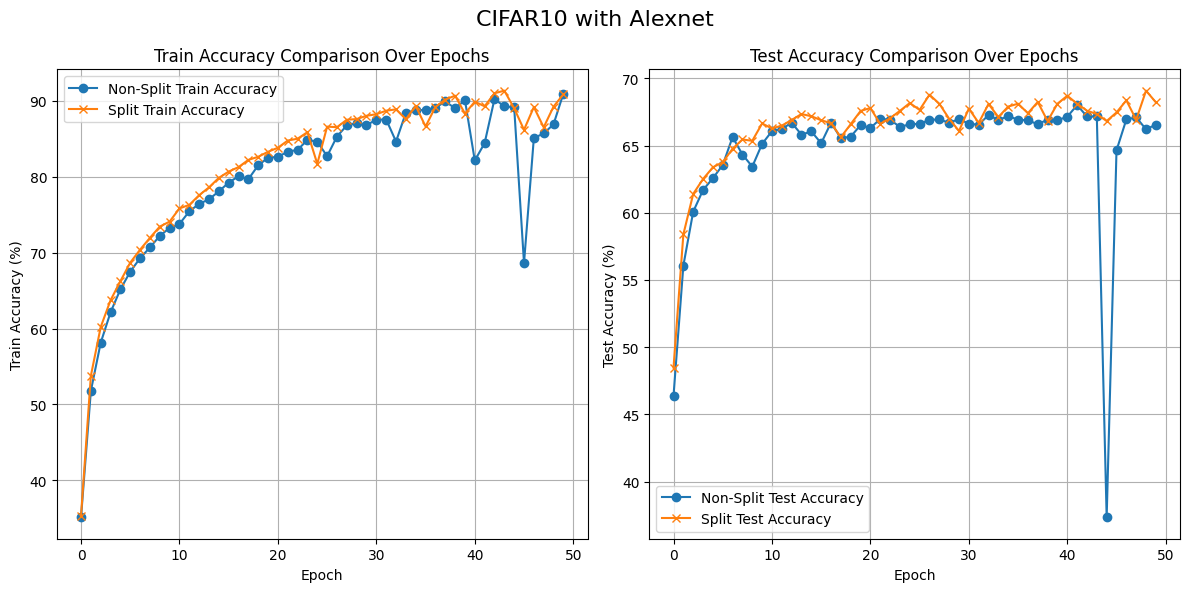

In [ ]:
def fix_to_50(s):
    return "\n".join([line for line in s.splitlines()[:50]])
plot_train_and_test_accuracy(fix_to_50(non_split_alex), fix_to_50(split_ver_alex), "Alexnet")

ECG